In [ ]:
import torch
import numpy as np
import torch.nn as nn
from tqdm.notebook import tqdm
import torchvision
import time
import itertools
import sklearn
from sklearn.model_selection import KFold

from torch.optim.lr_scheduler import StepLR

torch.manual_seed(42)

In [ ]:
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")
print("Device being used: ", device)

Device being used:  cuda


In [ ]:
scaled_mean= 0.13062754273414612
scaled_std= 0.30810779333114624

In [ ]:
train_dataset =  torchvision.datasets.MNIST('./data/files/', train=True, download=True,  transform=torchvision.transforms.Compose([
                                                                                       torchvision.transforms.ToTensor(),
                                                                                       torchvision.transforms.Normalize((scaled_mean,), (scaled_std,))]))
test_dataset =   torchvision.datasets.MNIST('./data/files/', train=False, download=True,  transform=torchvision.transforms.Compose([
                                                                                       torchvision.transforms.ToTensor(),
                                                                                       torchvision.transforms.Normalize((scaled_mean,), (scaled_std,))]))



Extracting ./data/files/MNIST/raw/train-images-idx3-ubyte.gz to ./data/files/MNIST/raw




Extracting ./data/files/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/files/MNIST/raw




Extracting ./data/files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/files/MNIST/raw




Extracting ./data/files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/files/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=use_gpu)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, pin_memory=use_gpu)

In [ ]:
print(f"Size of the train set: {len(train_loader.dataset)}, size of the test set: {len(test_loader.dataset)}")

Size of the train set: 60000, size of the test set: 10000


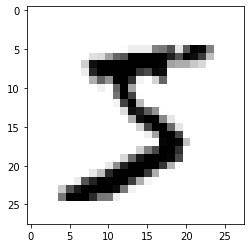

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset[0][0].numpy().squeeze(), cmap='gray_r');

In [ ]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
train_dataset[0][1]

5

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.linear1 = nn.Linear(28*28, 256) 
        self.linear2 = nn.Linear(256, 100) 
        self.final = nn.Linear(100, 10)
        self.relu = nn.ReLU()

    def forward(self, img): #convert + flatten
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.final(x)
        return x


In [ ]:
def reset_weights(m):
    '''
    Reset model weights to avoid weight leakage. Useful during hyperparameter tuning
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [ ]:
def train(model, dataloader, criterion, optimizer,mini_batch_size):
    '''
    Train the given model, using te specified train data (dataloader), loss (criterion) and optimizer
    '''
    for b in range(0, dataloader[0].size(0), mini_batch_size):
        if b+mini_batch_size < dataloader[0].shape[0]:
           batch_size = mini_batch_size
        else:
          batch_size = dataloader[0].shape[0] - b
        
        y_pred = model(dataloader[0].narrow(0, b, batch_size))
        
        loss = criterion(y_pred, dataloader[1].narrow(0, b, batch_size))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
import torch.nn.functional as F

def test(model, dataloader,mini_batch_size):
    '''
    Evaluate the accuracy of the given model, tested on the specified test set (dataloader)
    '''
    correct = 0.0
    total = 0.0
    for b in range(0, dataloader[0].size(0), mini_batch_size):

        ##if remaining batch is smaller than mini_batch_size, take last batch in a smaller batch size
        if b+mini_batch_size < dataloader[0].shape[0]:
           batch_size = mini_batch_size
        else:
          batch_size = dataloader[0].shape[0] - b
        
        with torch.no_grad():
            preds = model(dataloader[0].narrow(0, b, batch_size))           # output of linear
            probs = F.softmax(preds, dim=1) # probability distribution
            preds = probs.argmax(dim=1)      # most probable class (for each sample in the batch)

            correct += (preds ==  dataloader[1].narrow(0, b, batch_size)).sum()
            total += len(preds)
            
    return correct / total # accuracy

In [ ]:
def send_data_to_gpu(train_loader,test_loader):

  train_tensor = [[],[]]
  for elem in train_loader:
    train_tensor[0].append(elem[0])
    train_tensor[1].append(elem[1])
  train_tensor[0] = torch.cat(train_tensor[0],0).to(device)
  train_tensor[1] = torch.cat(train_tensor[1],0).to(device)

  test_tensor = [[],[]]
  for elem in test_loader:
    test_tensor[0].append(elem[0])
    test_tensor[1].append(elem[1])
  test_tensor[0] = torch.cat(test_tensor[0],0).to(device)
  test_tensor[1] = torch.cat(test_tensor[1],0).to(device)

  return train_tensor,test_tensor

train_loader,test_loader = send_data_to_gpu(train_loader,test_loader)  


# Quick test to see if things are working and to learn how LR-schedulers work

## Constant Learning Rate

In [ ]:

start_time = time.time()

model = Net()
model.to(device)

# train_loader,test_loader = send_data_to_gpu(train_loader,test_loader)
print(train_loader[0].device)
print(train_loader[1].device)
print(test_loader[0].device)
print(test_loader[1].device)


optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
#raise
#train_loader = train_loader.to(device)
#test_loader = test_loader.to(device)

for epoch in range(20):
    train(model, train_loader, torch.nn.CrossEntropyLoss(), optimizer,64)
    acc = test(model, test_loader,64)
    
    print(f'Epoch {epoch}: test accuracy {acc:.4}')
    
print(f"--- {((time.time() - start_time)/60):.4} minutes ---" )

cuda:0
cuda:0
cuda:0
cuda:0
Epoch 0: test accuracy 0.9538
Epoch 1: test accuracy 0.9638
Epoch 2: test accuracy 0.9745
Epoch 3: test accuracy 0.9788
Epoch 4: test accuracy 0.9801
Epoch 5: test accuracy 0.9814
Epoch 6: test accuracy 0.9813
Epoch 7: test accuracy 0.9812
Epoch 8: test accuracy 0.9813
Epoch 9: test accuracy 0.9813
Epoch 10: test accuracy 0.9825
Epoch 11: test accuracy 0.9825
Epoch 12: test accuracy 0.9828
Epoch 13: test accuracy 0.983
Epoch 14: test accuracy 0.9827
Epoch 15: test accuracy 0.9829
Epoch 16: test accuracy 0.983
Epoch 17: test accuracy 0.9832
Epoch 18: test accuracy 0.9831
Epoch 19: test accuracy 0.9831
--- 0.2759 minutes ---


# Experiments

In [ ]:
FOLDS = 1
EPOCHS = 25

### SGD Gamma

In [ ]:
from torch.optim.lr_scheduler import StepLR

acc_sgd_gam = [0]*EPOCHS

start_time = time.time()

for fold in range(FOLDS):
  print("Starting fold : ", fold+1 )

  model = Net()
  model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.2)
  scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

  for epoch in range(EPOCHS):
      print("The current lr : ", scheduler.get_lr())
      train(model, train_loader, torch.nn.CrossEntropyLoss(), optimizer,64)
      acc = test(model, test_loader,64)
      acc_sgd_gam[epoch] += acc

      scheduler.step()
      
      print(f'Epoch {epoch}: test accuracy {acc:.4}')

for i in range(len(acc_sgd_gam)): #Dividing by number of folds to get avg
  acc_sgd_gam[i] /= FOLDS
    
print(f"--- {((time.time() - start_time)/60):.4} minutes ---" )

Starting fold :  1
The current lr :  [0.2]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch 0: test accuracy 0.946
The current lr :  [0.16200000000000003]
Epoch 1: test accuracy 0.9713
The current lr :  [0.14580000000000004]
Epoch 2: test accuracy 0.9771
The current lr :  [0.13122000000000003]
Epoch 3: test accuracy 0.9784
The current lr :  [0.11809800000000004]
Epoch 4: test accuracy 0.9816
The current lr :  [0.10628820000000004]
Epoch 5: test accuracy 0.9807
The current lr :  [0.09565938000000004]
Epoch 6: test accuracy 0.9802
The current lr :  [0.08609344200000005]
Epoch 7: test accuracy 0.9818
The current lr :  [0.07748409780000004]
Epoch 8: test accuracy 0.982
The current lr :  [0.06973568802000003]
Epoch 9: test accuracy 0.9825
The current lr :  [0.06276211921800003]
Epoch 10: test accuracy 0.9828
The current lr :  [0.056485907296200025]
Epoch 11: test accuracy 0.983
The current lr :  [0.050837316566580026]
Epoch 12: test accuracy 0.9829
The current lr :  [0.04575358490992203]
Epoch 13: test accuracy 0.9832
The current lr :  [0.04117822641892983]
Epoch 14: test ac

### SGD ReduceLROnPlateau

Starting fold :  1
The current lr :  [0.4]
Epoch 0: test accuracy 0.9131
The current lr :  [0.4]
Epoch 1: test accuracy 0.9704
The current lr :  [0.4]
Epoch 2: test accuracy 0.9741
The current lr :  [0.4]
Epoch 3: test accuracy 0.9709
The current lr :  [0.4]
Epoch 4: test accuracy 0.9767
The current lr :  [0.4]
Epoch 5: test accuracy 0.9736
The current lr :  [0.4]
Epoch 6: test accuracy 0.9798
The current lr :  [0.4]
Epoch 7: test accuracy 0.9775
The current lr :  [0.4]
Epoch 8: test accuracy 0.9795
The current lr :  [0.4]
Epoch 9: test accuracy 0.9798
The current lr :  [0.12]
Epoch 10: test accuracy 0.9842
The current lr :  [0.12]
Epoch 11: test accuracy 0.9837
The current lr :  [0.12]
Epoch 12: test accuracy 0.9834
The current lr :  [0.12]
Epoch 13: test accuracy 0.9833
The current lr :  [0.036]
Epoch 14: test accuracy 0.9832
The current lr :  [0.036]
Epoch 15: test accuracy 0.9831
The current lr :  [0.036]
Epoch 16: test accuracy 0.9831
The current lr :  [0.010799999999999999]
Epoch

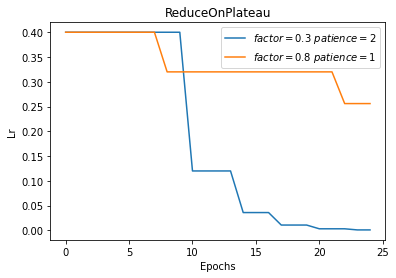

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

acc_sgd_red = [0]*EPOCHS

lr_evol1 = [0]*EPOCHS

start_time = time.time()
FOLDS = 1
for fold in range(FOLDS):
  print("Starting fold : ", fold+1 )

  model = Net()
  model.to(device)

  optimizer = torch.optim.SGD(model.parameters(), lr=0.4)

  scheduler = ReduceLROnPlateau(optimizer,patience=2, mode='max', factor= 0.3)

  for epoch in range(EPOCHS):
      print("The current lr : ", list(map(lambda x: x["lr"] ,scheduler.optimizer.param_groups)))
      lr_evol1[epoch] = scheduler.optimizer.param_groups[0]["lr"]

      train(model, train_loader, torch.nn.CrossEntropyLoss(), optimizer,64)
      acc = test(model, test_loader,64)
      acc_sgd_red[epoch] += acc
      
      scheduler.step(acc)
      
      print(f'Epoch {epoch}: test accuracy {acc:.4}')

for i in range(EPOCHS): #Dividing by number of folds to get avg
  acc_sgd_red[i] /= FOLDS
    
print(f"--- {((time.time() - start_time)/60):.4} minutes ---" )


######


acc_sgd_red = [0]*EPOCHS

lr_evol2 = [0]*EPOCHS

start_time = time.time()
FOLDS = 1
for fold in range(FOLDS):
  print("Starting fold : ", fold+1 )

  model = Net()
  model.to(device)

  optimizer = torch.optim.SGD(model.parameters(), lr=0.4)

  scheduler = ReduceLROnPlateau(optimizer,patience=1, mode='max', factor= 0.8)

  for epoch in range(EPOCHS):
      print("The current lr : ", list(map(lambda x: x["lr"] ,scheduler.optimizer.param_groups)))
      lr_evol2[epoch] = scheduler.optimizer.param_groups[0]["lr"]

      train(model, train_loader, torch.nn.CrossEntropyLoss(), optimizer,64)
      acc = test(model, test_loader,64)
      acc_sgd_red[epoch] += acc
      
      scheduler.step(acc)
      
      print(f'Epoch {epoch}: test accuracy {acc:.4}')

for i in range(EPOCHS): #Dividing by number of folds to get avg
  acc_sgd_red[i] /= FOLDS
    
print(f"--- {((time.time() - start_time)/60):.4} minutes ---" )


####


plt.plot(lr_evol1, label= "$factor = 0.3$ $patience =2$")
plt.plot(lr_evol2, label= "$factor = 0.8$ $patience =1$")
plt.legend()
plt.title("ReduceOnPlateau")
plt.xlabel("Epochs")
plt.ylabel("Lr")
plt.savefig("Reduce", dpi=100)
plt.show()

### SGD Cosine annealing schedule

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR

acc_sgd_cos = [0]*EPOCHS

start_time = time.time()

for fold in range(FOLDS):
  print("Starting fold : ", fold+1 )

  model = Net()
  model.to(device)

  optimizer = torch.optim.SGD(model.parameters(), lr=0.2)
  T_max = 3
  eta_min = 0.01 #minimum learning rate
  scheduler = CosineAnnealingLR(optimizer, T_max, eta_min=eta_min)

  for epoch in range(EPOCHS):
      print("The current lr : ", scheduler.get_lr())

      train(model, train_loader, torch.nn.CrossEntropyLoss(), optimizer,64)
      acc = test(model, test_loader,64)
      acc_sgd_cos[epoch] += acc
      
      scheduler.step()
      
      print(f'Epoch {epoch}: test accuracy {acc:.4}')

  

for i in range(EPOCHS): #Dividing by number of folds to get avg
  acc_sgd_cos[i] /= FOLDS
    
print(f"--- {((time.time() - start_time)/60):.4} minutes ---" )

Starting fold :  1
The current lr :  [0.2]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:509: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch 0: test accuracy 0.9345
The current lr :  [0.116875]
Epoch 1: test accuracy 0.9724
The current lr :  [0.025833333333333347]
Epoch 2: test accuracy 0.9787
The current lr :  [0.01]
Epoch 3: test accuracy 0.9799
The current lr :  [0.10499999999999998]
Epoch 4: test accuracy 0.9796
The current lr :  [0.43750000000000067]
Epoch 5: test accuracy 0.979
The current lr :  [0.2633333333333335]
Epoch 6: test accuracy 0.9768
The current lr :  [0.11687500000000012]
Epoch 7: test accuracy 0.9778
The current lr :  [0.02583333333333339]
Epoch 8: test accuracy 0.981
The current lr :  [0.01]
Epoch 9: test accuracy 0.9824
The current lr :  [0.10499999999999998]
Epoch 10: test accuracy 0.9819
The current lr :  [0.43749999999999906]
Epoch 11: test accuracy 0.9803
The current lr :  [0.26333333333333336]
Epoch 12: test accuracy 0.9301
The current lr :  [0.11687499999999992]
Epoch 13: test accuracy 0.9804
The current lr :  [0.02583333333333339]
Epoch 14: test accuracy 0.9833
The current lr :  [0.01]
Epo

### SGD Lambda

In [ ]:
from torch.optim.lr_scheduler import LambdaLR

acc_sgd_lam = [0]*EPOCHS

start_time = time.time()

for fold in range(FOLDS):
  print("Starting fold : ", fold+1 )

  model = Net()
  model.to(device)

  optimizer = torch.optim.SGD(model.parameters(), lr=0.4)
  lr_lambda = lambda epoch: 1/((epoch)//3+1)**2  #For each epoch, this will be multiplied by the learning rate
  scheduler = LambdaLR(optimizer, lr_lambda)

  for epoch in range(EPOCHS):
      print("The current lr : ", scheduler.get_lr())

      train(model, train_loader, torch.nn.CrossEntropyLoss(), optimizer,64)
      acc = test(model, test_loader,64)
      acc_sgd_lam[epoch] += acc
      
      scheduler.step()
      
      print(f'Epoch {epoch}: test accuracy {acc:.4}')

  

for i in range(EPOCHS): #Dividing by number of folds to get avg
  acc_sgd_lam[i] /= FOLDS
    
print(f"--- {((time.time() - start_time)/60):.4} minutes ---" )

Starting fold :  1
The current lr :  [0.4]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 0: test accuracy 0.9164
The current lr :  [0.4]
Epoch 1: test accuracy 0.9625
The current lr :  [0.4]
Epoch 2: test accuracy 0.9734
The current lr :  [0.1]
Epoch 3: test accuracy 0.9815
The current lr :  [0.1]
Epoch 4: test accuracy 0.9817
The current lr :  [0.1]
Epoch 5: test accuracy 0.9818
The current lr :  [0.044444444444444446]
Epoch 6: test accuracy 0.9826
The current lr :  [0.044444444444444446]
Epoch 7: test accuracy 0.9827
The current lr :  [0.044444444444444446]
Epoch 8: test accuracy 0.9827
The current lr :  [0.025]
Epoch 9: test accuracy 0.9833
The current lr :  [0.025]
Epoch 10: test accuracy 0.9832
The current lr :  [0.025]
Epoch 11: test accuracy 0.9831
The current lr :  [0.016]
Epoch 12: test accuracy 0.9831
The current lr :  [0.016]
Epoch 13: test accuracy 0.983
The current lr :  [0.016]
Epoch 14: test accuracy 0.983
The current lr :  [0.011111111111111112]
Epoch 15: test accuracy 0.9833
The current lr :  [0.011111111111111112]
Epoch 16: test accuracy 0.9832
The 

### Adagrad

In [ ]:
from torch.optim import Adagrad

acc_adag= [0]*EPOCHS

start_time = time.time()

for fold in range(FOLDS):
  print("Starting fold : ", fold+1 )

  model = Net()
  model.to(device)

  optimizer = torch.optim.Adagrad(model.parameters(), lr=0.008)
  lr_lambda = lambda epoch: 1  #For each epoch, this will be multiplied by the learning rate
  scheduler = LambdaLR(optimizer, lr_lambda)

  for epoch in range(EPOCHS):
      print("The current lr : ", scheduler.get_lr())

      train(model, train_loader, torch.nn.CrossEntropyLoss(), optimizer,64)
      acc = test(model, test_loader,64)
      acc_adag[epoch] += acc

      scheduler.step()
      
      print(f'Epoch {epoch}: test accuracy {acc:.4}')


for i in range(len(acc_sgd_gam)): #Dividing by number of folds to get avg
  acc_adag[i] /= FOLDS
    
print(f"--- {((time.time() - start_time)/60):.4} minutes ---" )

Starting fold :  1
The current lr :  [0.008]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 0: test accuracy 0.9593
The current lr :  [0.008]
Epoch 1: test accuracy 0.9696
The current lr :  [0.008]
Epoch 2: test accuracy 0.9741
The current lr :  [0.008]
Epoch 3: test accuracy 0.9757
The current lr :  [0.008]
Epoch 4: test accuracy 0.9764
The current lr :  [0.008]
Epoch 5: test accuracy 0.9769
The current lr :  [0.008]
Epoch 6: test accuracy 0.9772
The current lr :  [0.008]
Epoch 7: test accuracy 0.9786
The current lr :  [0.008]
Epoch 8: test accuracy 0.979
The current lr :  [0.008]
Epoch 9: test accuracy 0.9793
The current lr :  [0.008]
Epoch 10: test accuracy 0.9794
The current lr :  [0.008]
Epoch 11: test accuracy 0.9798
The current lr :  [0.008]
Epoch 12: test accuracy 0.9796
The current lr :  [0.008]
Epoch 13: test accuracy 0.9802
The current lr :  [0.008]
Epoch 14: test accuracy 0.9802
The current lr :  [0.008]
Epoch 15: test accuracy 0.9804
The current lr :  [0.008]
Epoch 16: test accuracy 0.9801
The current lr :  [0.008]
Epoch 17: test accuracy 0.9804
The current

### AdaDelta

In [ ]:
from torch.optim import Adadelta

acc_adad = [0]*EPOCHS

start_time = time.time()

for fold in range(FOLDS):
  print("Starting fold : ", fold+1 )

  model = Net()
  model.to(device)

  optimizer = torch.optim.Adadelta(model.parameters(), lr=0.4)
  lr_lambda = lambda epoch: 1  #For each epoch, this will be multiplied by the learning rate
  scheduler = LambdaLR(optimizer, lr_lambda)

  for epoch in range(EPOCHS):
      print("The current lr : ", scheduler.get_lr())

      train(model, train_loader, torch.nn.CrossEntropyLoss(), optimizer,64)
      acc = test(model, test_loader,64)
      acc_adad[epoch] += acc
      
      scheduler.step()
      
      print(f'Epoch {epoch}: test accuracy {acc:.4}')


for i in range(len(acc_sgd_gam)): #Dividing by number of folds to get avg
  acc_adad[i] /= FOLDS

print(f"--- {((time.time() - start_time)/60):.4} minutes ---" )

Starting fold :  1
The current lr :  [0.4]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 0: test accuracy 0.9603
The current lr :  [0.4]
Epoch 1: test accuracy 0.9705
The current lr :  [0.4]
Epoch 2: test accuracy 0.9768
The current lr :  [0.4]
Epoch 3: test accuracy 0.9785
The current lr :  [0.4]
Epoch 4: test accuracy 0.9796
The current lr :  [0.4]
Epoch 5: test accuracy 0.9795
The current lr :  [0.4]
Epoch 6: test accuracy 0.9821
The current lr :  [0.4]
Epoch 7: test accuracy 0.9802
The current lr :  [0.4]
Epoch 8: test accuracy 0.9807
The current lr :  [0.4]
Epoch 9: test accuracy 0.9808
The current lr :  [0.4]
Epoch 10: test accuracy 0.9816
The current lr :  [0.4]
Epoch 11: test accuracy 0.9812
The current lr :  [0.4]
Epoch 12: test accuracy 0.981
The current lr :  [0.4]
Epoch 13: test accuracy 0.9816
The current lr :  [0.4]
Epoch 14: test accuracy 0.9818
The current lr :  [0.4]
Epoch 15: test accuracy 0.9826
The current lr :  [0.4]
Epoch 16: test accuracy 0.9829
The current lr :  [0.4]
Epoch 17: test accuracy 0.9828
The current lr :  [0.4]
Epoch 18: test accura

### Adam

In [ ]:
from torch.optim import Adam

acc_adam = [0]*EPOCHS

start_time = time.time()

for fold in range(FOLDS):
  print("Starting fold : ", fold+1 )

  model = Net()
  model.to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
  lr_lambda = lambda epoch: 1  #For each epoch, this will be multiplied by the learning rate
  scheduler = LambdaLR(optimizer, lr_lambda)

  for epoch in range(EPOCHS):
      print("The current lr : ", scheduler.get_lr())
      # print("Opt : ", optimizer.state_dict()["param_groups"])
      train(model, train_loader, torch.nn.CrossEntropyLoss(), optimizer,64)
      acc = test(model, test_loader,64)
      acc_adam[epoch] += acc

      scheduler.step()
      
      print(f'Epoch {epoch}: test accuracy {acc:.4}')

for i in range(len(acc_sgd_gam)): #Dividing by number of folds to get avg
  acc_adam[i] /= FOLDS

print(f"--- {((time.time() - start_time)/60):.4} minutes ---" )

Starting fold :  1
The current lr :  [0.002]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 0: test accuracy 0.9625
The current lr :  [0.002]
Epoch 1: test accuracy 0.9684
The current lr :  [0.002]
Epoch 2: test accuracy 0.974
The current lr :  [0.002]
Epoch 3: test accuracy 0.9729
The current lr :  [0.002]
Epoch 4: test accuracy 0.978
The current lr :  [0.002]
Epoch 5: test accuracy 0.9645
The current lr :  [0.002]
Epoch 6: test accuracy 0.9742
The current lr :  [0.002]
Epoch 7: test accuracy 0.9706
The current lr :  [0.002]
Epoch 8: test accuracy 0.9741
The current lr :  [0.002]
Epoch 9: test accuracy 0.9755
The current lr :  [0.002]
Epoch 10: test accuracy 0.9738
The current lr :  [0.002]
Epoch 11: test accuracy 0.9759
The current lr :  [0.002]
Epoch 12: test accuracy 0.9792
The current lr :  [0.002]
Epoch 13: test accuracy 0.9716
The current lr :  [0.002]
Epoch 14: test accuracy 0.9666
The current lr :  [0.002]
Epoch 15: test accuracy 0.9774
The current lr :  [0.002]
Epoch 16: test accuracy 0.9772
The current lr :  [0.002]
Epoch 17: test accuracy 0.9766
The current 

# Comparing optimizers

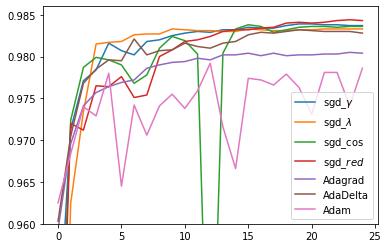

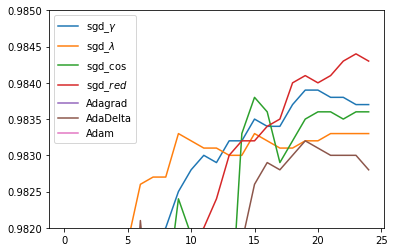

In [ ]:
import pylab as plt

plt.plot(acc_sgd_gam, label="sgd_$\gamma$")
plt.plot(acc_sgd_lam, label="sgd_$\lambda$")
plt.plot(acc_sgd_cos, label="sgd_$\cos$")
plt.plot(acc_sgd_red, label="sgd_${red}$")
plt.plot(acc_adag, label= "Adagrad")
plt.plot(acc_adad, label = "AdaDelta")
plt.plot(acc_adam, label = "Adam")
plt.ylim(0.96,0.986)
plt.legend()
plt.show()

plt.plot(acc_sgd_gam, label="sgd_$\gamma$")
plt.plot(acc_sgd_lam, label="sgd_$\lambda$")
plt.plot(acc_sgd_cos, label="sgd_$\cos$")
plt.plot(acc_sgd_red, label="sgd_${red}$")
plt.plot(acc_adag, label= "Adagrad")
plt.plot(acc_adad, label = "AdaDelta")
plt.plot(acc_adam, label = "Adam")
plt.ylim(0.982,0.985)
plt.legend()
plt.show()

# k_fold Cross Validation and Hyperparameter Tuning

In [ ]:
def train_with_cross_validation(model, parameters):
    '''
    Perform a K-fold training with CV using the specified parameters.
    This is done by splitting the train set into K-different folds, and performing a training and testing step 
    using the compinations of the folds as new training and validation sets.
    
    This whole procedure is done using the specified parameters for number of folds, loss function, number of epochs, batch size, and optimizer.
    '''
    
    #Define the Kfold to be used when splitting the training dataset
    kfold = KFold(n_splits=parameters["folds"], shuffle = True)
    results = {}
    
    #Itereate K number of times, each time changing the indeces of the train/validation sets
    for fold, (train_index, validation_index) in enumerate(kfold.split(train_dataset)):
        
        print(" -Fold Nr: ", fold+1)
        
        # Create the Training and Validation sets, using the assigned indeces
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_index)
        validation_subsampler = torch.utils.data.SubsetRandomSampler(validation_index)
        
        #Use the previous datasets to create DataLoaders with the specified batch_size
        train_loader_Kfold = torch.utils.data.DataLoader(train_dataset, sampler=train_subsampler, batch_size=parameters["batch_size"], pin_memory=use_gpu)
        validation_loader_Kfold  = torch.utils.data.DataLoader(train_dataset, sampler=validation_subsampler, batch_size=parameters["batch_size"], pin_memory=use_gpu)


        torch.cuda.empty_cache()
        train_loader_Kfold , validation_loader_Kfold = send_data_to_gpu(train_loader_Kfold,validation_loader_Kfold)

        #Reset the model weights for the new iteration
        model.apply(reset_weights)
        
        #Define the criterion, optimizer and scheduler as specified in the parameters
        criterion = parameters["criterion"]()

        optimizer = parameters["optimizer"](model.parameters(), lr=parameters["lr"])   
        
        scheduler = parameters["scheduler"](optimizer, **parameters["scheduler_parameters"])
       

        #Repeat the training step 'epoch'-number of times. Keep track of the accuracy when testing on the current validation set
        prev_val_accuracy = 0
        for epoch in range(parameters["epochs"]):
            
            train(model, train_loader_Kfold, criterion, optimizer,parameters["batch_size"])
            
            current_accuracy = 100.0 * (test(model, validation_loader_Kfold,parameters["batch_size"]))

            print(f"      Epoch: {epoch+1}/{parameters['epochs']}, Validation Score: {current_accuracy:.4}")

            '''
            #Early stopping
            if(current_accuracy < prev_val_accuracy):
              break
            '''
            prev_val_accuracy = current_accuracy
            try:
              scheduler.step()
            except:
              scheduler.step(current_accuracy)

        results[fold] = current_accuracy

    # Print fold results
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    avg_acc = sum/len(results.items())
    print(f'   Average validation score of the {parameters["folds"]} folds : {avg_acc:.4} %')
    print('--------------------------------')
        
    return avg_acc

In [ ]:
def grid_search(model, parameters):
    '''
    Perform a grid search on the model using the given parameters, calling K-fold cross validation for each combination. 
    After all the combinations of parameters have been tried, return the parameters that had the best average validation accuracy.
    '''

    start_time = time.time()

    keys, values = zip(*parameters.items())
    permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    best_acc = 0.0
    best_settings = {}
    
    for params in tqdm(permutations_dicts):
        print("-CURRENT PARAMETERS : ", params)
        acc = train_with_cross_validation(model, params)
        
        if acc > best_acc:
            best_acc = acc
            best_settings = params
    print(f"Best overall accuracy {best_acc} for these parameters {best_settings}")
    
    print(f"--- Total time: {((time.time() - start_time)/60):.4} minutes ---" )

    return best_settings, best_acc

In [ ]:
#This is just an example
parameters_SGD_StepLR = {
    "criterion": [torch.nn.CrossEntropyLoss],
    "optimizer": [torch.optim.SGD, torch.optim.Adam, torch.optim.Adagrad, torch.optim.Adadelta],
    "scheduler": [StepLR],
    "scheduler_parameters": [{'step_size':2, 'gamma':0.5}, {'step_size':2, 'gamma':0.8}, {'step_size':2, 'gamma':0.95} ],
    "lr": [0.5, 0.05],
    "batch_size": [50, 100],
    "folds": [3],
    "epochs": [30]
}

In [ ]:
model = Net()
model.to(device)

best_parameters_gam, best_accuracy_gam = grid_search(model, parameters_SGD_StepLR)

best_parameters_gam

In [ ]:
best_accuracy_gam

In [ ]:
best_parameters_gam

{'batch_size': 100,
 'criterion': torch.nn.modules.loss.CrossEntropyLoss,
 'epochs': 30,
 'folds': 3,
 'lr': 0.5,
 'optimizer': torch.optim.adadelta.Adadelta,
 'scheduler': torch.optim.lr_scheduler.StepLR,
 'scheduler_parameters': {'gamma': 0.95, 'step_size': 2}}

In [ ]:
parameters_SGD_StepLR = {
    "criterion": [torch.nn.CrossEntropyLoss],
    "optimizer": [torch.optim.SGD, torch.optim.Adadelta],
    "scheduler": [ReduceLROnPlateau],
    "scheduler_parameters": [{'patience': 2, 'mode': 'max', 'factor': 0.3}, {'patience':2, 'mode':'max', 'factor': 0.5}, {'patience':4, 'mode':'max', 'factor': 0.3}, {'patience':4, 'mode':'max', 'factor': 0.1}],
    "lr": [0.4, 0.05],
    "batch_size": [30,60,90],
    "folds": [5],
    "epochs": [30]
}

In [ ]:
model = Net()
model.to(device)

best_parameters_red, best_accuracy_red = grid_search(model, parameters_SGD_StepLR)

best_parameters_red

Streaming output truncated to the last 5000 lines.
      Epoch: 24/30, Validation Score: 97.78
      Epoch: 25/30, Validation Score: 97.78
      Epoch: 26/30, Validation Score: 97.78
      Epoch: 27/30, Validation Score: 97.78
      Epoch: 28/30, Validation Score: 97.78
      Epoch: 29/30, Validation Score: 97.78
      Epoch: 30/30, Validation Score: 97.8
 -Fold Nr:  3
      Epoch: 1/30, Validation Score: 91.29
      Epoch: 2/30, Validation Score: 93.44
      Epoch: 3/30, Validation Score: 95.39
      Epoch: 4/30, Validation Score: 96.37
      Epoch: 5/30, Validation Score: 96.72
      Epoch: 6/30, Validation Score: 96.85
      Epoch: 7/30, Validation Score: 97.13
      Epoch: 8/30, Validation Score: 97.24
      Epoch: 9/30, Validation Score: 97.41
      Epoch: 10/30, Validation Score: 97.53
      Epoch: 11/30, Validation Score: 97.55
      Epoch: 12/30, Validation Score: 97.58
      Epoch: 13/30, Validation Score: 97.61
      Epoch: 14/30, Validation Score: 97.68
      Epoch: 15/30, V

{'batch_size': 90,
 'criterion': torch.nn.modules.loss.CrossEntropyLoss,
 'epochs': 30,
 'folds': 5,
 'lr': 0.4,
 'optimizer': torch.optim.sgd.SGD,
 'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau,
 'scheduler_parameters': {'factor': 0.5, 'mode': 'max', 'patience': 2}}

In [ ]:
best_accuracy_red

tensor(98.2300, device='cuda:0')

In [ ]:
best_parameters_red

{'batch_size': 90,
 'criterion': torch.nn.modules.loss.CrossEntropyLoss,
 'epochs': 30,
 'folds': 5,
 'lr': 0.4,
 'optimizer': torch.optim.sgd.SGD,
 'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau,
 'scheduler_parameters': {'factor': 0.5, 'mode': 'max', 'patience': 2}}

In [ ]:
parameters_SGD_StepLR = {
    "criterion": [torch.nn.CrossEntropyLoss],
    "optimizer": [torch.optim.SGD, torch.optim.Adadelta],
    "scheduler": [CosineAnnealingLR],
    "scheduler_parameters": [{"T_max":3, "eta_min":0.01}, {"T_max":5, "eta_min":0.01}, {"T_max":8, "eta_min":0.01}, {"T_max":12, "eta_min":0.01}],
    "lr": [0.4, 0.05],
    "batch_size": [30,60,90],
    "folds": [5],
    "epochs": [30]
}

In [ ]:
model = Net()
model.to(device)

best_parameters_cos, best_accuracy_cos = grid_search(model, parameters_SGD_StepLR)

best_parameters_cos

Streaming output truncated to the last 5000 lines.
      Epoch: 24/30, Validation Score: 97.61
      Epoch: 25/30, Validation Score: 97.59
      Epoch: 26/30, Validation Score: 97.59
      Epoch: 27/30, Validation Score: 97.63
      Epoch: 28/30, Validation Score: 97.66
      Epoch: 29/30, Validation Score: 97.66
      Epoch: 30/30, Validation Score: 97.64
 -Fold Nr:  3
      Epoch: 1/30, Validation Score: 92.76
      Epoch: 2/30, Validation Score: 94.87
      Epoch: 3/30, Validation Score: 95.99
      Epoch: 4/30, Validation Score: 96.44
      Epoch: 5/30, Validation Score: 96.93
      Epoch: 6/30, Validation Score: 97.07
      Epoch: 7/30, Validation Score: 97.19
      Epoch: 8/30, Validation Score: 97.29
      Epoch: 9/30, Validation Score: 97.38
      Epoch: 10/30, Validation Score: 97.4
      Epoch: 11/30, Validation Score: 97.42
      Epoch: 12/30, Validation Score: 97.46
      Epoch: 13/30, Validation Score: 97.53
      Epoch: 14/30, Validation Score: 97.54
      Epoch: 15/30, V

{'batch_size': 90,
 'criterion': torch.nn.modules.loss.CrossEntropyLoss,
 'epochs': 30,
 'folds': 5,
 'lr': 0.4,
 'optimizer': torch.optim.sgd.SGD,
 'scheduler': torch.optim.lr_scheduler.CosineAnnealingLR,
 'scheduler_parameters': {'T_max': 8, 'eta_min': 0.01}}

In [ ]:
best_accuracy_cos

tensor(98.1950, device='cuda:0')

In [ ]:
best_parameters_cos

{'batch_size': 90,
 'criterion': torch.nn.modules.loss.CrossEntropyLoss,
 'epochs': 30,
 'folds': 5,
 'lr': 0.4,
 'optimizer': torch.optim.sgd.SGD,
 'scheduler': torch.optim.lr_scheduler.CosineAnnealingLR,
 'scheduler_parameters': {'T_max': 8, 'eta_min': 0.01}}

In [ ]:
def lr_lambda_1(epoch):
  return 1  #For each epoch, this will be multiplied by the learning rate
def lr_lambda_2(epoch):
  return 1/((epoch)//3+1)  #For each epoch, this will be multiplied by the learning rate
def lr_lambda_3(epoch):
  return 1/((epoch)//3+1)**2  #For each epoch, this will be multiplied by the learning rate

parameters_SGD_StepLR = {
    "criterion": [torch.nn.CrossEntropyLoss],
    "optimizer": [torch.optim.SGD, torch.optim.Adadelta],
    "scheduler": [LambdaLR],
    "scheduler_parameters": [{"lr_lambda" : lr_lambda_1}, {"lr_lambda" : lr_lambda_2}, {"lr_lambda" : lr_lambda_3}],
    "lr": [0.4, 0.05],
    "batch_size": [30,60,90],
    "folds": [5],
    "epochs": [30]
}

In [ ]:
model = Net()
model.to(device)

best_parameters_lam, best_accuracy_lam = grid_search(model, parameters_SGD_StepLR)

best_parameters_lam

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
      Epoch: 24/30, Validation Score: 97.86
      Epoch: 25/30, Validation Score: 97.85
      Epoch: 26/30, Validation Score: 97.88
      Epoch: 27/30, Validation Score: 97.9
      Epoch: 28/30, Validation Score: 97.9
      Epoch: 29/30, Validation Score: 97.91
      Epoch: 30/30, Validation Score: 97.91
 -Fold Nr:  3
      Epoch: 1/30, Validation Score: 92.48
      Epoch: 2/30, Validation Score: 94.85
      Epoch: 3/30, Validation Score: 95.97
      Epoch: 4/30, Validation Score: 96.46
      Epoch: 5/30, Validation Score: 96.78
      Epoch: 6/30, Validation Score: 96.96
      Epoch: 7/30, Validation Score: 97.21
      Epoch: 8/30, Validation Score: 97.38
      Epoch: 9/30, Validation Score: 97.48
      Epoch: 10/30, Validation Score: 97.57
      Epoch: 11/30, Validation Score: 97.69
      Epoch: 12/30, Validation Score: 97.73
      Epoch: 13/30, Validation Score: 97.79
      Epoch: 14/30, Validation Score: 9

{'batch_size': 90,
 'criterion': torch.nn.modules.loss.CrossEntropyLoss,
 'epochs': 30,
 'folds': 5,
 'lr': 0.4,
 'optimizer': torch.optim.sgd.SGD,
 'scheduler': torch.optim.lr_scheduler.LambdaLR,
 'scheduler_parameters': {'lr_lambda': <function __main__.lr_lambda_1>}}

In [ ]:
best_accuracy_lam

tensor(98.2117, device='cuda:0')

In [ ]:
best_parameters_lam

{'batch_size': 90,
 'criterion': torch.nn.modules.loss.CrossEntropyLoss,
 'epochs': 30,
 'folds': 5,
 'lr': 0.4,
 'optimizer': torch.optim.sgd.SGD,
 'scheduler': torch.optim.lr_scheduler.LambdaLR,
 'scheduler_parameters': {'lr_lambda': <function __main__.lr_lambda_1>}}

# Personalized CV

##Common variables

In [ ]:
# For LambdaLR
def lr_lambda_1(epoch):
  return 1  #For each epoch, this will be multiplied by the learning rate
def lr_lambda_2(epoch):
  return 1/((epoch)//3+1)  #For each epoch, this will be multiplied by the learning rate
def lr_lambda_3(epoch):
  return 1/((epoch)//3+1)**2  #For each epoch, this will be multiplied by the learning rate
def lr_lambda_4(epoch):
  return 1/((epoch)//4+1)**2  #For each epoch, this will be multiplied by the learning rate
def lr_lambda_5(epoch):
  return 1/((epoch)//4+1)**3  #For each epoch, this will be multiplied by the learning rate
def lr_lambda_6(epoch):
  return 1/((epoch)//5+1)**3  #For each epoch, this will be multiplied by the learning rate
def lr_lambda_7(epoch):
  return np.exp(-epoch/4)  #For each epoch, this will be multiplied by the learning rate
def lr_lambda_8(epoch):
  return np.exp(-epoch/7)  #For each epoch, this will be multiplied by the learning rate

# Common part of the parameters
parameters = {
    "criterion": [torch.nn.CrossEntropyLoss],
    "lr": [0.4, 0.2, 0.05],
    "batch_size": [90],
    "folds": [5],
    "epochs": [25]
}

## SGD

In [ ]:
parameters["optimizer"] = [torch.optim.SGD]

### LambdaLR

In [ ]:
parameters["scheduler"]= [LambdaLR]
parameters["scheduler_parameters"]= [{"lr_lambda" : lr_lambda_2}, {"lr_lambda" : lr_lambda_3}, {"lr_lambda": lr_lambda_4},
                                     {"lr_lambda" : lr_lambda_5}, {"lr_lambda" : lr_lambda_6}, {"lr_lambda" : lr_lambda_7}, {"lr_lambda": lr_lambda_8}]

model = Net()
model.to(device)

grid_search(model, parameters)

-CURRENT PARAMETERS :  {'criterion': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'lr': 0.4, 'batch_size': 90, 'folds': 5, 'epochs': 25, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'scheduler': <class 'torch.optim.lr_scheduler.LambdaLR'>, 'scheduler_parameters': {'lr_lambda': <function lr_lambda_2 at 0x7f88ec39f0e0>}}
 -Fold Nr:  1
      Epoch: 1/25, Validation Score: 95.23
      Epoch: 2/25, Validation Score: 96.75
      Epoch: 3/25, Validation Score: 97.41
      Epoch: 4/25, Validation Score: 97.92
      Epoch: 5/25, Validation Score: 98.14
      Epoch: 6/25, Validation Score: 98.14
      Epoch: 7/25, Validation Score: 98.1
      Epoch: 8/25, Validation Score: 98.18
      Epoch: 9/25, Validation Score: 98.18
      Epoch: 10/25, Validation Score: 98.2
      Epoch: 11/25, Validation Score: 98.21
      Epoch: 12/25, Validation Score: 98.22
      Epoch: 13/25, Validation Score: 98.22
      Epoch: 14/25, Validation Score: 98.23
      Epoch: 15/25, Validation Score: 98.22
      Epoch:

({'batch_size': 90,
  'criterion': torch.nn.modules.loss.CrossEntropyLoss,
  'epochs': 25,
  'folds': 5,
  'lr': 0.4,
  'optimizer': torch.optim.sgd.SGD,
  'scheduler': torch.optim.lr_scheduler.LambdaLR,
  'scheduler_parameters': {'lr_lambda': <function __main__.lr_lambda_6>}},
 tensor(98.1317, device='cuda:0'))

### ReduceLROnPlateau

In [ ]:
parameters["scheduler"]= [ReduceLROnPlateau]
parameters["scheduler_parameters"]= [{'patience': 2, 'mode': 'max', 'factor': 0.3}, {'patience':2, 'mode':'max', 'factor': 0.5}, {'patience':4, 'mode':'max', 'factor': 0.5}, {'patience':4, 'mode':'max', 'factor': 0.3}, {'patience':4, 'mode':'max', 'factor': 0.1}]

model = Net()
model.to(device)

grid_search(model, parameters)

-CURRENT PARAMETERS :  {'criterion': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'lr': 0.4, 'batch_size': 90, 'folds': 5, 'epochs': 25, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_parameters': {'patience': 2, 'mode': 'max', 'factor': 0.3}}
 -Fold Nr:  1
      Epoch: 1/25, Validation Score: 82.54
      Epoch: 2/25, Validation Score: 90.57
      Epoch: 3/25, Validation Score: 96.06
      Epoch: 4/25, Validation Score: 96.95
      Epoch: 5/25, Validation Score: 97.31
      Epoch: 6/25, Validation Score: 92.62
      Epoch: 7/25, Validation Score: 97.32
      Epoch: 8/25, Validation Score: 97.17
      Epoch: 9/25, Validation Score: 97.12
      Epoch: 10/25, Validation Score: 97.65
      Epoch: 11/25, Validation Score: 97.69
      Epoch: 12/25, Validation Score: 97.64
      Epoch: 13/25, Validation Score: 97.62
      Epoch: 14/25, Validation Score: 97.74
      Epoch: 15/25, Validation Score: 97.72
      Epoch

({'batch_size': 90,
  'criterion': torch.nn.modules.loss.CrossEntropyLoss,
  'epochs': 25,
  'folds': 5,
  'lr': 0.4,
  'optimizer': torch.optim.sgd.SGD,
  'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau,
  'scheduler_parameters': {'factor': 0.3, 'mode': 'max', 'patience': 2}},
 tensor(98.1967, device='cuda:0'))

###Cosine annealing

In [ ]:
parameters["scheduler"]= [CosineAnnealingLR]
parameters["scheduler_parameters"]= [{"T_max":3, "eta_min":0.01}, {"T_max":5, "eta_min":0.01}, {"T_max":8, "eta_min":0.01}, {"T_max":12, "eta_min":0.01},
                                     {"T_max":3, "eta_min":0.03}, {"T_max":5, "eta_min":0.03}, {"T_max":8, "eta_min":0.03}, {"T_max":12, "eta_min":0.03}]

model = Net()
model.to(device)

grid_search(model, parameters)

-CURRENT PARAMETERS :  {'criterion': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'lr': 0.4, 'batch_size': 90, 'folds': 5, 'epochs': 25, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'scheduler': <class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, 'scheduler_parameters': {'T_max': 3, 'eta_min': 0.01}}
 -Fold Nr:  1
      Epoch: 1/25, Validation Score: 95.7
      Epoch: 2/25, Validation Score: 97.19
      Epoch: 3/25, Validation Score: 97.9
      Epoch: 4/25, Validation Score: 98.05
      Epoch: 5/25, Validation Score: 97.99
      Epoch: 6/25, Validation Score: 97.77
      Epoch: 7/25, Validation Score: 97.44
      Epoch: 8/25, Validation Score: 97.78
      Epoch: 9/25, Validation Score: 98.14
      Epoch: 10/25, Validation Score: 98.22
      Epoch: 11/25, Validation Score: 98.2
      Epoch: 12/25, Validation Score: 98.11
      Epoch: 13/25, Validation Score: 93.62
      Epoch: 14/25, Validation Score: 97.97
      Epoch: 15/25, Validation Score: 98.12
      Epoch: 16/25, Validation

({'batch_size': 90,
  'criterion': torch.nn.modules.loss.CrossEntropyLoss,
  'epochs': 25,
  'folds': 5,
  'lr': 0.4,
  'optimizer': torch.optim.sgd.SGD,
  'scheduler': torch.optim.lr_scheduler.CosineAnnealingLR,
  'scheduler_parameters': {'T_max': 3, 'eta_min': 0.03}},
 tensor(98.1950, device='cuda:0'))

###Step LR ($\gamma$)

In [ ]:
parameters["scheduler"]= [StepLR]
parameters["scheduler_parameters"]= [{'step_size':2, 'gamma':0.5}, {'step_size':2, 'gamma':0.8}, {'step_size':2, 'gamma':0.95},
                                     {'step_size':4, 'gamma':0.3}, {'step_size':4, 'gamma':0.7}, {'step_size':4, 'gamma':0.85}]

model = Net()
model.to(device)

grid_search(model, parameters)

-CURRENT PARAMETERS :  {'criterion': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'lr': 0.4, 'batch_size': 90, 'folds': 5, 'epochs': 25, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'scheduler_parameters': {'step_size': 2, 'gamma': 0.5}}
 -Fold Nr:  1
      Epoch: 1/25, Validation Score: 86.35
      Epoch: 2/25, Validation Score: 95.82
      Epoch: 3/25, Validation Score: 97.57
      Epoch: 4/25, Validation Score: 97.66
      Epoch: 5/25, Validation Score: 97.78
      Epoch: 6/25, Validation Score: 97.79
      Epoch: 7/25, Validation Score: 97.71
      Epoch: 8/25, Validation Score: 97.73
      Epoch: 9/25, Validation Score: 97.79
      Epoch: 10/25, Validation Score: 97.82
      Epoch: 11/25, Validation Score: 97.85
      Epoch: 12/25, Validation Score: 97.84
      Epoch: 13/25, Validation Score: 97.85
      Epoch: 14/25, Validation Score: 97.84
      Epoch: 15/25, Validation Score: 97.85
      Epoch: 16/25, Validation Score:

({'batch_size': 90,
  'criterion': torch.nn.modules.loss.CrossEntropyLoss,
  'epochs': 25,
  'folds': 5,
  'lr': 0.4,
  'optimizer': torch.optim.sgd.SGD,
  'scheduler': torch.optim.lr_scheduler.StepLR,
  'scheduler_parameters': {'gamma': 0.85, 'step_size': 4}},
 tensor(98.1750, device='cuda:0'))

## AdaDelta

In [ ]:
parameters["lr"] = [0.4, 0.2, 0.05, 0.02]
parameters["optimizer"] = [torch.optim.Adadelta]

### LambdaLR

In [ ]:
parameters["scheduler"]= [LambdaLR]
parameters["scheduler_parameters"]= [ {"lr_lambda" : lr_lambda_2}, {"lr_lambda" : lr_lambda_3}, {"lr_lambda": lr_lambda_4},
                                     {"lr_lambda" : lr_lambda_5}, {"lr_lambda" : lr_lambda_6}, {"lr_lambda" : lr_lambda_7}, {"lr_lambda": lr_lambda_8}]

model = Net()
model.to(device)

grid_search(model, parameters)

-CURRENT PARAMETERS :  {'criterion': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'lr': 0.4, 'batch_size': 90, 'folds': 5, 'epochs': 25, 'optimizer': <class 'torch.optim.adadelta.Adadelta'>, 'scheduler': <class 'torch.optim.lr_scheduler.LambdaLR'>, 'scheduler_parameters': {'lr_lambda': <function lr_lambda_2 at 0x7f88ec39f0e0>}}
 -Fold Nr:  1
      Epoch: 1/25, Validation Score: 94.23
      Epoch: 2/25, Validation Score: 96.38
      Epoch: 3/25, Validation Score: 96.96
      Epoch: 4/25, Validation Score: 97.62
      Epoch: 5/25, Validation Score: 97.68
      Epoch: 6/25, Validation Score: 97.72
      Epoch: 7/25, Validation Score: 97.81
      Epoch: 8/25, Validation Score: 97.87
      Epoch: 9/25, Validation Score: 97.9
      Epoch: 10/25, Validation Score: 97.93
      Epoch: 11/25, Validation Score: 97.93
      Epoch: 12/25, Validation Score: 97.88
      Epoch: 13/25, Validation Score: 97.93
      Epoch: 14/25, Validation Score: 97.96
      Epoch: 15/25, Validation Score: 97.95
 

({'batch_size': 90,
  'criterion': torch.nn.modules.loss.CrossEntropyLoss,
  'epochs': 25,
  'folds': 5,
  'lr': 0.4,
  'optimizer': torch.optim.adadelta.Adadelta,
  'scheduler': torch.optim.lr_scheduler.LambdaLR,
  'scheduler_parameters': {'lr_lambda': <function __main__.lr_lambda_5>}},
 tensor(98.0350, device='cuda:0'))

### ReduceLROnPlateau

In [ ]:
parameters["scheduler"]= [ReduceLROnPlateau]
parameters["scheduler_parameters"]= [{'patience': 2, 'mode': 'max', 'factor': 0.3}, {'patience':2, 'mode':'max', 'factor': 0.5}, {'patience':4, 'mode':'max', 'factor': 0.5},
                                     {'patience':4, 'mode':'max', 'factor': 0.3}, {'patience':4, 'mode':'max', 'factor': 0.1}]

model = Net()
model.to(device)

grid_search(model, parameters)

-CURRENT PARAMETERS :  {'criterion': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'lr': 0.4, 'batch_size': 90, 'folds': 5, 'epochs': 25, 'optimizer': <class 'torch.optim.adadelta.Adadelta'>, 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_parameters': {'patience': 2, 'mode': 'max', 'factor': 0.3}}
 -Fold Nr:  1
      Epoch: 1/25, Validation Score: 95.52
      Epoch: 2/25, Validation Score: 96.85
      Epoch: 3/25, Validation Score: 97.27
      Epoch: 4/25, Validation Score: 97.36
      Epoch: 5/25, Validation Score: 97.4
      Epoch: 6/25, Validation Score: 97.44
      Epoch: 7/25, Validation Score: 97.7
      Epoch: 8/25, Validation Score: 97.68
      Epoch: 9/25, Validation Score: 97.81
      Epoch: 10/25, Validation Score: 97.62
      Epoch: 11/25, Validation Score: 97.76
      Epoch: 12/25, Validation Score: 97.78
      Epoch: 13/25, Validation Score: 97.89
      Epoch: 14/25, Validation Score: 97.94
      Epoch: 15/25, Validation Score: 97.93
   

({'batch_size': 90,
  'criterion': torch.nn.modules.loss.CrossEntropyLoss,
  'epochs': 25,
  'folds': 5,
  'lr': 0.4,
  'optimizer': torch.optim.adadelta.Adadelta,
  'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau,
  'scheduler_parameters': {'factor': 0.1, 'mode': 'max', 'patience': 4}},
 tensor(98.1350, device='cuda:0'))

###Cosine annealing

In [ ]:
parameters["scheduler"]= [CosineAnnealingLR]
parameters["scheduler_parameters"]= [{"T_max":3, "eta_min":0.01}, {"T_max":5, "eta_min":0.01}, {"T_max":8, "eta_min":0.01}, {"T_max":12, "eta_min":0.01},
                                     {"T_max":3, "eta_min":0.03}, {"T_max":5, "eta_min":0.03}, {"T_max":8, "eta_min":0.03}, {"T_max":12, "eta_min":0.03}]

model = Net()
model.to(device)

grid_search(model, parameters)

-CURRENT PARAMETERS :  {'criterion': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'lr': 0.4, 'batch_size': 90, 'folds': 5, 'epochs': 25, 'optimizer': <class 'torch.optim.adadelta.Adadelta'>, 'scheduler': <class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, 'scheduler_parameters': {'T_max': 3, 'eta_min': 0.01}}
 -Fold Nr:  1
      Epoch: 1/25, Validation Score: 95.5
      Epoch: 2/25, Validation Score: 96.85
      Epoch: 3/25, Validation Score: 97.22
      Epoch: 4/25, Validation Score: 97.48
      Epoch: 5/25, Validation Score: 97.44
      Epoch: 6/25, Validation Score: 97.3
      Epoch: 7/25, Validation Score: 97.33
      Epoch: 8/25, Validation Score: 97.74
      Epoch: 9/25, Validation Score: 97.87
      Epoch: 10/25, Validation Score: 97.92
      Epoch: 11/25, Validation Score: 97.88
      Epoch: 12/25, Validation Score: 97.92
      Epoch: 13/25, Validation Score: 97.78
      Epoch: 14/25, Validation Score: 97.99
      Epoch: 15/25, Validation Score: 97.96
      Epoch: 16/25,

({'batch_size': 90,
  'criterion': torch.nn.modules.loss.CrossEntropyLoss,
  'epochs': 25,
  'folds': 5,
  'lr': 0.4,
  'optimizer': torch.optim.adadelta.Adadelta,
  'scheduler': torch.optim.lr_scheduler.CosineAnnealingLR,
  'scheduler_parameters': {'T_max': 8, 'eta_min': 0.01}},
 tensor(98.1000, device='cuda:0'))

###Step LR ($\gamma$)

In [ ]:
parameters["scheduler"]= [StepLR]
parameters["scheduler_parameters"]= [{'step_size':2, 'gamma':0.5}, {'step_size':2, 'gamma':0.8}, {'step_size':2, 'gamma':0.95},
                                     {'step_size':4, 'gamma':0.3}, {'step_size':4, 'gamma':0.7}, {'step_size':4, 'gamma':0.85}]

model = Net()
model.to(device)

grid_search(model, parameters)

-CURRENT PARAMETERS :  {'criterion': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'lr': 0.4, 'batch_size': 90, 'folds': 5, 'epochs': 25, 'optimizer': <class 'torch.optim.adadelta.Adadelta'>, 'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'scheduler_parameters': {'step_size': 2, 'gamma': 0.5}}
 -Fold Nr:  1
      Epoch: 1/25, Validation Score: 95.58
      Epoch: 2/25, Validation Score: 96.92
      Epoch: 3/25, Validation Score: 97.34
      Epoch: 4/25, Validation Score: 97.4
      Epoch: 5/25, Validation Score: 97.75
      Epoch: 6/25, Validation Score: 97.72
      Epoch: 7/25, Validation Score: 97.87
      Epoch: 8/25, Validation Score: 97.9
      Epoch: 9/25, Validation Score: 97.92
      Epoch: 10/25, Validation Score: 97.91
      Epoch: 11/25, Validation Score: 97.93
      Epoch: 12/25, Validation Score: 97.93
      Epoch: 13/25, Validation Score: 97.93
      Epoch: 14/25, Validation Score: 97.93
      Epoch: 15/25, Validation Score: 97.94
      Epoch: 16/25, Validatio

({'batch_size': 90,
  'criterion': torch.nn.modules.loss.CrossEntropyLoss,
  'epochs': 25,
  'folds': 5,
  'lr': 0.4,
  'optimizer': torch.optim.adadelta.Adadelta,
  'scheduler': torch.optim.lr_scheduler.StepLR,
  'scheduler_parameters': {'gamma': 0.95, 'step_size': 2}},
 tensor(98.0633, device='cuda:0'))

## Adam

In [ ]:
parameters["lr"] = [0.4, 0.2, 0.05, 0.02]
parameters["optimizer"] = [torch.optim.Adam]

### LambdaLR

In [ ]:
parameters["scheduler"]= [LambdaLR]
parameters["scheduler_parameters"]= [{"lr_lambda" : lr_lambda_1}, {"lr_lambda" : lr_lambda_2}, {"lr_lambda" : lr_lambda_3}, {"lr_lambda": lr_lambda_4},
                                     {"lr_lambda" : lr_lambda_5}, {"lr_lambda" : lr_lambda_6}, {"lr_lambda" : lr_lambda_7}, {"lr_lambda": lr_lambda_8}]

model = Net()
model.to(device)

grid_search(model, parameters)

-CURRENT PARAMETERS :  {'criterion': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'lr': 0.4, 'batch_size': 90, 'folds': 5, 'epochs': 25, 'optimizer': <class 'torch.optim.adam.Adam'>, 'scheduler': <class 'torch.optim.lr_scheduler.LambdaLR'>, 'scheduler_parameters': {'lr_lambda': <function lr_lambda_1 at 0x7f6af5662d40>}}
 -Fold Nr:  1
      Epoch: 1/25, Validation Score: 9.55
      Epoch: 2/25, Validation Score: 9.558
      Epoch: 3/25, Validation Score: 11.02
      Epoch: 4/25, Validation Score: 11.02
      Epoch: 5/25, Validation Score: 11.02
      Epoch: 6/25, Validation Score: 11.02
      Epoch: 7/25, Validation Score: 11.02
      Epoch: 8/25, Validation Score: 11.02
      Epoch: 9/25, Validation Score: 11.02
      Epoch: 10/25, Validation Score: 11.02
      Epoch: 11/25, Validation Score: 11.02
      Epoch: 12/25, Validation Score: 11.02
      Epoch: 13/25, Validation Score: 11.02
      Epoch: 14/25, Validation Score: 11.02
      Epoch: 15/25, Validation Score: 11.02
      Epo

({'batch_size': 90,
  'criterion': torch.nn.modules.loss.CrossEntropyLoss,
  'epochs': 25,
  'folds': 5,
  'lr': 0.02,
  'optimizer': torch.optim.adam.Adam,
  'scheduler': torch.optim.lr_scheduler.LambdaLR,
  'scheduler_parameters': {'lr_lambda': <function __main__.lr_lambda_7>}},
 tensor(96.4367, device='cuda:0'))

### ReduceLROnPlateau

In [ ]:
parameters["scheduler"]= [ReduceLROnPlateau]
parameters["scheduler_parameters"]= [{'patience': 2, 'mode': 'max', 'factor': 0.3}, {'patience':2, 'mode':'max', 'factor': 0.5}, {'patience':4, 'mode':'max', 'factor': 0.5},
                                     {'patience':4, 'mode':'max', 'factor': 0.3}, {'patience':4, 'mode':'max', 'factor': 0.1}]

model = Net()
model.to(device)

grid_search(model, parameters)

-CURRENT PARAMETERS :  {'criterion': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'lr': 0.4, 'batch_size': 90, 'folds': 5, 'epochs': 25, 'optimizer': <class 'torch.optim.adam.Adam'>, 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_parameters': {'patience': 2, 'mode': 'max', 'factor': 0.3}}
 -Fold Nr:  1
      Epoch: 1/25, Validation Score: 10.02
      Epoch: 2/25, Validation Score: 10.02
      Epoch: 3/25, Validation Score: 9.9
      Epoch: 4/25, Validation Score: 9.9
      Epoch: 5/25, Validation Score: 10.33
      Epoch: 6/25, Validation Score: 10.33
      Epoch: 7/25, Validation Score: 10.33
      Epoch: 8/25, Validation Score: 10.33
      Epoch: 9/25, Validation Score: 10.33
      Epoch: 10/25, Validation Score: 10.33
      Epoch: 11/25, Validation Score: 10.33
      Epoch: 12/25, Validation Score: 11.58
      Epoch: 13/25, Validation Score: 11.58
      Epoch: 14/25, Validation Score: 11.58
      Epoch: 15/25, Validation Score: 11.58
      Epoch: 

({'batch_size': 90,
  'criterion': torch.nn.modules.loss.CrossEntropyLoss,
  'epochs': 25,
  'folds': 5,
  'lr': 0.02,
  'optimizer': torch.optim.adam.Adam,
  'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau,
  'scheduler_parameters': {'factor': 0.5, 'mode': 'max', 'patience': 2}},
 tensor(95.9350, device='cuda:0'))

###Cosine annealing

In [ ]:
parameters["scheduler"]= [CosineAnnealingLR]
parameters["scheduler_parameters"]= [{"T_max":3, "eta_min":0.01}, {"T_max":5, "eta_min":0.01}, {"T_max":8, "eta_min":0.01}, {"T_max":12, "eta_min":0.01},
                                     {"T_max":3, "eta_min":0.03}, {"T_max":5, "eta_min":0.03}, {"T_max":8, "eta_min":0.03}, {"T_max":12, "eta_min":0.03}]

model = Net()
model.to(device)

grid_search(model, parameters)

-CURRENT PARAMETERS :  {'criterion': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'lr': 0.4, 'batch_size': 90, 'folds': 5, 'epochs': 25, 'optimizer': <class 'torch.optim.adam.Adam'>, 'scheduler': <class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, 'scheduler_parameters': {'T_max': 3, 'eta_min': 0.01}}
 -Fold Nr:  1
      Epoch: 1/25, Validation Score: 9.625
      Epoch: 2/25, Validation Score: 9.633
      Epoch: 3/25, Validation Score: 10.57
      Epoch: 4/25, Validation Score: 11.54
      Epoch: 5/25, Validation Score: 10.57
      Epoch: 6/25, Validation Score: 9.633
      Epoch: 7/25, Validation Score: 11.54
      Epoch: 8/25, Validation Score: 9.633
      Epoch: 9/25, Validation Score: 10.57
      Epoch: 10/25, Validation Score: 11.54
      Epoch: 11/25, Validation Score: 10.57
      Epoch: 12/25, Validation Score: 9.633
      Epoch: 13/25, Validation Score: 11.54
      Epoch: 14/25, Validation Score: 9.633
      Epoch: 15/25, Validation Score: 10.57
      Epoch: 16/25, Valid

({'batch_size': 90,
  'criterion': torch.nn.modules.loss.CrossEntropyLoss,
  'epochs': 25,
  'folds': 5,
  'lr': 0.02,
  'optimizer': torch.optim.adam.Adam,
  'scheduler': torch.optim.lr_scheduler.CosineAnnealingLR,
  'scheduler_parameters': {'T_max': 5, 'eta_min': 0.01}},
 tensor(95.3167, device='cuda:0'))

###Step LR ($\gamma$)

In [ ]:
parameters["scheduler"]= [StepLR]
parameters["scheduler_parameters"]= [{'step_size':2, 'gamma':0.5}, {'step_size':2, 'gamma':0.8}, {'step_size':2, 'gamma':0.95},
                                     {'step_size':4, 'gamma':0.3}, {'step_size':4, 'gamma':0.7}, {'step_size':4, 'gamma':0.85}]

model = Net()
model.to(device)

grid_search(model, parameters)

-CURRENT PARAMETERS :  {'criterion': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'lr': 0.4, 'batch_size': 90, 'folds': 5, 'epochs': 25, 'optimizer': <class 'torch.optim.adam.Adam'>, 'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'scheduler_parameters': {'step_size': 2, 'gamma': 0.5}}
 -Fold Nr:  1
      Epoch: 1/25, Validation Score: 9.742
      Epoch: 2/25, Validation Score: 9.742
      Epoch: 3/25, Validation Score: 9.742
      Epoch: 4/25, Validation Score: 9.742
      Epoch: 5/25, Validation Score: 9.492
      Epoch: 6/25, Validation Score: 9.492
      Epoch: 7/25, Validation Score: 9.492
      Epoch: 8/25, Validation Score: 9.492
      Epoch: 9/25, Validation Score: 11.21
      Epoch: 10/25, Validation Score: 11.21
      Epoch: 11/25, Validation Score: 11.21
      Epoch: 12/25, Validation Score: 11.21
      Epoch: 13/25, Validation Score: 11.21
      Epoch: 14/25, Validation Score: 11.21
      Epoch: 15/25, Validation Score: 11.21
      Epoch: 16/25, Validation Scor

({'batch_size': 90,
  'criterion': torch.nn.modules.loss.CrossEntropyLoss,
  'epochs': 25,
  'folds': 5,
  'lr': 0.02,
  'optimizer': torch.optim.adam.Adam,
  'scheduler': torch.optim.lr_scheduler.StepLR,
  'scheduler_parameters': {'gamma': 0.5, 'step_size': 2}},
 tensor(96.3817, device='cuda:0'))

# Schedulers 

In [ ]:
EPOCHS = 25

## StepLR

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


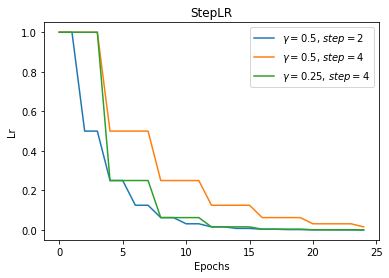

In [ ]:
from torch.optim.lr_scheduler import StepLR


scheduler1 = StepLR(torch.optim.SGD(model.parameters(), lr=1), 2, 0.5)
scheduler2 = StepLR(torch.optim.SGD(model.parameters(), lr=1), 4, 0.5)
scheduler3 = StepLR(torch.optim.SGD(model.parameters(), lr=1), 4, 0.25)
scheduler4 = StepLR(torch.optim.SGD(model.parameters(), lr=1), 6, 0.25)

lr_evol1 = [0]*EPOCHS
lr_evol2 = [0]*EPOCHS
lr_evol3 = [0]*EPOCHS
lr_evol4 = [0]*EPOCHS

for epoch in range(EPOCHS):
  lr_evol1[epoch] = scheduler1.get_last_lr()[0]
  lr_evol2[epoch] = scheduler2.get_last_lr()[0]
  lr_evol3[epoch] = scheduler3.get_last_lr()[0]
  lr_evol4[epoch] = scheduler4.get_last_lr()[0]

  scheduler1.step()
  scheduler2.step()
  scheduler3.step()
  scheduler4.step()

plt.plot(lr_evol1, label="$\gamma = 0.5$, $step = 2$")
plt.plot(lr_evol2, label="$\gamma = 0.5$, $step = 4$")
plt.plot(lr_evol3, label="$\gamma = 0.25$, $step = 4$")

plt.legend()
plt.title("StepLR")
plt.xlabel("Epochs")
plt.ylabel("Lr")
plt.savefig("StepLr", dpi=100)
plt.show()

##CosineAnnealingLR

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


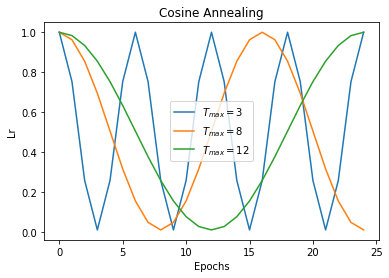

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR


scheduler1 = CosineAnnealingLR(torch.optim.SGD(model.parameters(), lr=1), 3, eta_min=0.01)
scheduler2 = CosineAnnealingLR(torch.optim.SGD(model.parameters(), lr=1), 8, eta_min=0.01)
scheduler3 = CosineAnnealingLR(torch.optim.SGD(model.parameters(), lr=1), 12, eta_min=0.01)
scheduler4 = CosineAnnealingLR(torch.optim.SGD(model.parameters(), lr=1), 15, eta_min=0.01)

lr_evol1 = [0]*EPOCHS
lr_evol2 = [0]*EPOCHS
lr_evol3 = [0]*EPOCHS
lr_evol4 = [0]*EPOCHS

for epoch in range(EPOCHS):
  
  lr_evol1[epoch] = scheduler1.get_last_lr()[0]
  lr_evol2[epoch] = scheduler2.get_last_lr()[0]
  lr_evol3[epoch] = scheduler3.get_last_lr()[0]
  lr_evol4[epoch] = scheduler4.get_last_lr()[0]

  scheduler1.step()
  scheduler2.step()
  scheduler3.step()
  scheduler4.step()

plt.plot(lr_evol1, label="$T_{max} = 3$")
plt.plot(lr_evol2, label="$T_{max} = 8$")
plt.plot(lr_evol3, label="$T_{max} = 12$")

plt.legend()
plt.title("Cosine Annealing")
plt.xlabel("Epochs")
plt.ylabel("Lr")
plt.savefig("Cos", dpi=100)
plt.show()

##LambdaLR

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


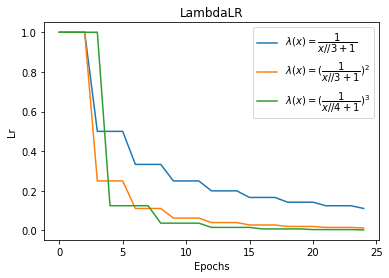

In [ ]:
from torch.optim.lr_scheduler import LambdaLR

def lr_lambda_test_1(epoch):
  return 1/((epoch)//3+1)  #For each epoch, this will be multiplied by the learning rate
def lr_lambda_test_2(epoch):
  return 1/((epoch)//3+1)**2  #For each epoch, this will be multiplied by the learning rate
def lr_lambda_test_3(epoch):
  return 1/((epoch)//4+1)**3  #For each epoch, this will be multiplied by the learning rate

scheduler1 = LambdaLR(torch.optim.SGD(model.parameters(), lr=1), lr_lambda_test_1 )
scheduler2 = LambdaLR(torch.optim.SGD(model.parameters(), lr=1), lr_lambda_test_2 )
scheduler3 = LambdaLR(torch.optim.SGD(model.parameters(), lr=1), lr_lambda_test_3 )

lr_evol1 = [0]*EPOCHS
lr_evol2 = [0]*EPOCHS
lr_evol3 = [0]*EPOCHS

for epoch in range(EPOCHS):
  
  lr_evol1[epoch] = scheduler1.get_last_lr()[0]
  lr_evol2[epoch] = scheduler2.get_last_lr()[0]
  lr_evol3[epoch] = scheduler3.get_last_lr()[0]

  scheduler1.step()
  scheduler2.step()
  scheduler3.step()

plt.plot(lr_evol1, label="$\lambda(x) = \dfrac{1}{x//3 +1}$")
plt.plot(lr_evol2, label="$\lambda(x) = (\dfrac{1}{x//3 +1})^2$")
plt.plot(lr_evol3, label="$\lambda(x) = (\dfrac{1}{x//4 +1})^3$")

plt.legend()
plt.title("LambdaLR")
plt.xlabel("Epochs")
plt.ylabel("Lr")
plt.savefig("Lambda", dpi=100)
plt.show()